# MC - Covid-19 Data preparation

Task description: https://ds-spaces.technik.fhnw.ch/app/uploads/sites/82/2020/09/minichallenge_covid19.pdf

Author: Roman Janic Studer

Data Pipeline Concept: https://en.wikipedia.org/wiki/Pipeline_(computing) (Zustandsänderung, Konfigurierbarkeit!)

## Procedure

1. [x] Create function for daily data pull
2. [x] Drop unneccesary data
3. [x] Clean data (tidy data principe)
4. [X] Prepare data for visualization (aggregation maybe)
5. [x] Return global and local dataframe
6. [x] Create visualization (plotly) for global and local data (barplots incl. moving average e. g. srf.ch and linecharts)
7. [x] Document process and code

Steps 1 to 5 should function as a data preparation pipeline

In [72]:
# TODO: Anderes Dataset verwenden (daily reports)
# Datasource local = https://github.com/daenuprobst/covid19-cases-switzerland
# Datasource global = https://github.com/CSSEGISandData/COVID-19

# Imports
import pandas as pd
from datetime import date, timedelta
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error

## get_data()
This function pulls 4 dataframes from two github repositories. Two dataframes from the John Hopkins University containing the daily total cases and total fatalities of Covid-19 from every country, and two from the covid19-cases-switzerland repository from David Probst containing daily total cases and total fatalities of Covid-19 from every Canton in Switzerland. The function utilises the `pandas.read_csv()` function and pulls the data directly via an URL to the raw data. It returns a List of DataFrames.

In [2]:
def get_data():
    """
    Pulls latest data from sources
    :return df_global: Dataframe containg current Covid-19 Data from John Hopkins University
    :return df_CH_cases: Daily new cases in Switzerland
    :return df_CH_fatal: Daily new fatalities in Switzerland
    """
    
    # Get most recent data from john hopkins
    df_global_daily_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')    
    df_global_daily_fatal = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    
    # Get most recent data from covid19-cases-switzerland
    df_CH_cases = pd.read_csv('https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland_openzh-phase2.csv')
    df_CH_fatal = pd.read_csv('https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_fatalities_switzerland_openzh-phase2.csv')
        
    return [df_global_daily_cases, df_global_daily_fatal, df_CH_cases, df_CH_fatal]

## drop_columns()
Muliple columns are not necessary for the data visualization and get dropped with `pandas.DataFrame.drop()`.

In [3]:
def drop_columns(dfs):
    """
    Drops columns in list of dataframes if column name is in columns
    :param dfs: Lisst of dataframes
    :return dfs: List of dataframes
    """
    DROP_COLUMNS = ['FIPS','Admin2','Province_State','Recovered','Combined_Key',
                'Incidence_Rate','Case-Fatality_Ratio', 'Province/State', 'Last_Update', 'Long','Lat']
    
    for df in dfs:
        columns = df.columns.intersection(DROP_COLUMNS) # get list of columns to drop
        df.drop(columns=columns, inplace=True)
    return dfs

## rename()
To get more uniform data and therefore less complication in later processes, it is useful to rename columns to have uniform names.

In [4]:
def rename(dfs):
    """
    Rename Columns with same information to get uniform columns across dataframes (easier down the line)
    :param dfs: List of dataframes
    :return dfs: List of dataframes with equal column names
    """
    for df in dfs:
        if 'Country_Region' in df.columns or 'Country/Region' in df.columns:
            df.rename({'Country_Region':'country',
                       'Country/Region':'country'}, inplace=True, axis=1)
        if 'Date' in df.columns:
            df.rename({'Date':'date'}, inplace=True, axis=1)
    return dfs

## drop_nan()
Drops empty rows

In [5]:
def drop_nan(dfs):
    """
    Drops empty rows
    :param dfs: Lisst of dataframes
    :return dfs: List of dataframes without NAN rows
    """
    for df in dfs:
        df.dropna(how='all', inplace=True)
    return dfs

## groupby_country()
The two DataFrames of John Hopkins University have countries that occur several times because they have been divided into provinces/states. For example, the USA occurs several times because its numbers are given per state. These numbers can be summed up to get only one line for each country.

In [6]:
def groupby_country(dfs):
    """
    Group data by Country or. Canton
    :param dfs: List of dataframes
    :return dfs: List of dataframes all grouped by country or Canton
    """
    for i,df in enumerate(dfs):
        # World data
        if 'country' in df.columns:
            df_copy = df.copy()
            df_copy = df_copy[['country']]
            
            # get all columns which should be summed up. I.e. all collumns with case numbers
            columns = [e for e in df.columns if e not in ['country']] 
            
            # group by country and sum up the case numbers
            df = df.groupby(by=['country'])[columns].agg('sum').reset_index() 
            
            # merge on original list
            df = df.merge(df_copy, left_on='country', right_on='country') 
            
            # drop duplicated countries
            dfs[i] = df.drop_duplicates(subset='country', keep='first') 
            
    return dfs

## melt_data()
This function is the heart of the pipeline. It melts the Dataframes and calculates the new columns.
To avoid problems with the calculation of the new daily cases (it can happen that data from one country is combined with data from another country), the DataFrames are divided per country/canton, the new data is calculated and finally merged into one DataFrame.

`pandas.DataFrame.melt()` led to some problems with the John Hopkins Data (calculation of "new_cases/fatal" led to negativ numbers, which should not be possible). Another approach was used as a workaround.

In [7]:
def melt_data(dfs):
    # TODO: Groupby for countries evtl. apply
    """
    Melts DataFrames into format "country"("canton"),"date","total_cases","new_cases","total_fatal","new_fatal"
    :param dfs: List of Dataframes
    :return dfs: List of Dataframes in new format
    """
    label = ['cases','fatal','cases','fatal']
    
    for i, df in enumerate(dfs):
        
        # global data
        if 'country' in df.columns:
            df_new = None
            for c in df.country.unique():
                df_c = df[df['country']==c].copy()
                
                # transpose DataFrame
                df_c  = df_c.T.reset_index() 
                
                # clean dataset and rename columns
                df_c.columns = ['date',f'total_{label[i]}']
                df_c = df_c.drop(0)
                
                # calculate new columns
                df_c[f'new_{label[i]}'] = df_c[f'total_{label[i]}'].diff() # new_cases/fatal column
                
                df_c['country'] = c
                
                if df_new is None:
                    df_new = df_c
                else:
                    df_new = df_new.append(other=df_c,ignore_index=True)
                    
            # add new_data
            dfs[i] = df_new
            
        # local data
        else:
            df_new = None
            # melt dataframe
            df = df.melt(id_vars='date',var_name='canton',value_name=f'total_{label[i]}')
            for c in df.canton.unique():
                df_c = df[df['canton']==c].copy()
                
                # calculate new columns
                df_c[f'new_{label[i]}'] = df_c[f'total_{label[i]}'].diff() # new_cases/fatal column
                
                if df_new is None:
                    df_new = df_c
                else:
                    df_new = df_new.append(other=df_c,ignore_index=True)
            
            # add new_data
            dfs[i] = df_new
            
    return dfs

## merge_data()
This function merges the four DataFrames into df_global and df_local

In [8]:
def merge_data(dfs):
    """
    Merges prepared Dataframes into two dataframes (df_global and df_local)
    :param dfs: List of DataFrames
    :return df_global: DataFrame containing Covid-Data for every country
    :return df_local: DataFrame containing Covid-Data for every canton in switzerland
    """
    df_global, df_local = None, None
    
    for df in dfs:
        if 'country' in df.columns:
            if df_global is None:
                df_global = df
            else:
                df_global = df_global.merge(right=df, on=['country','date'],how='left')
        elif 'canton' in df.columns:
            if df_local is None:
                df_local = df
            else:
                df_local = df_local.merge(right=df, on=['canton','date'],how='left')

    return df_global, df_local

## covid_pipe()
Strings all the above mentioned functions together to form a pipeline 

In [9]:
def covid_pipe():
    """
    Covid-19 data pipeline
    :return df_global: DataFrame containing total_cases, new_cases, total_fatal (fatalities), 
                       new_fatal for every day and country since tracking
    :return df_local: DataFrame containing total_cases, new_cases, total_fatal (fatalities), 
                      new_fatal for every day and canton in switzerland since tracking
    """
    dfs = get_data()
    dfs = drop_columns(dfs)
    dfs = rename(dfs)
    dfs = drop_nan(dfs)
    dfs = groupby_country(dfs)

    dfs = melt_data(dfs)
    df_global, df_local = merge_data(dfs)
    
    return df_global, df_local

In [10]:
df_global, df_local = covid_pipe()

## Output of pipeline

In [56]:
df_local.head()

,date,canton,total_cases,new_cases,total_fatal,new_fatal
0,2020-05-31,AG,0.0,NaN,0.0,NaN
1,2020-06-01,AG,0.0,0.0,0.0,0.0
2,2020-06-02,AG,0.0,0.0,0.0,0.0
3,2020-06-03,AG,1.0,1.0,0.0,0.0
4,2020-06-04,AG,3.0,2.0,0.0,0.0


In [58]:
df_global[df_global['country'] == 'Switzerland'][1:]

,date,total_cases,new_cases,country,total_fatal,new_fatal
41077,1/23/20,0,0,Switzerland,0,0
41078,1/24/20,0,0,Switzerland,0,0
41079,1/25/20,0,0,Switzerland,0,0
41080,1/26/20,0,0,Switzerland,0,0
41081,1/27/20,0,0,Switzerland,0,0
...,...,...,...,...,...,...
41323,9/25/20,51864,372,Switzerland,2064,3
41324,9/26/20,51864,0,Switzerland,2064,0
41325,9/27/20,51864,0,Switzerland,2064,0
41326,9/28/20,52646,782,Switzerland,2065,1


# ARIMA Forecast
AutoRegressive Integrated Moving Average

Target: Predict total cases per country
Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

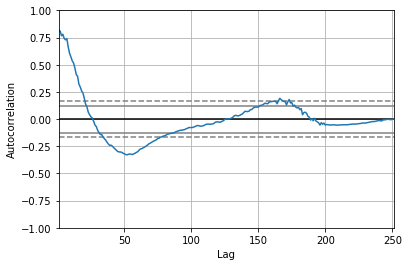

In [77]:
# note that no NA is allowed
df_ch = df_global[df_global['country'] == 'Switzerland'][1:][['date','new_cases']]

df_ch = df_ch.set_index('date')
autocorrelation_plot(df_ch)
pyplot.show()

In [78]:
t = np.asarray(df_ch['new_cases'])

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  250
Model:                ARIMA(10, 1, 0)   Log Likelihood               -1581.056
Method:                       css-mle   S.D. of innovations            134.521
Date:                Wed, 30 Sep 2020   AIC                           3186.113
Time:                        18:52:23   BIC                           3228.370
Sample:                             1   HQIC                          3203.120
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8205      5.642      0.145      0.884     -10.238      11.879
ar.L1.D.y     -0.6674      0.063    -10.567      0.000      -0.791      -0.544
ar.L2.D.y     -0.3586      0.076     -4.739      0.0

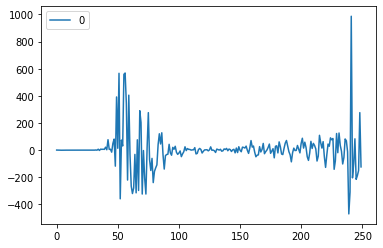

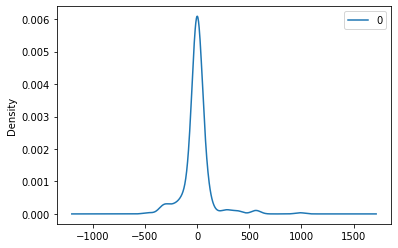

                0
count  250.000000
mean     0.014783
std    134.790674
min   -472.102745
25%    -22.709758
50%     -1.222673
75%     20.029692
max    987.015740


In [79]:
model = ARIMA(t, order=(10,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

Test MSE: 28468.151


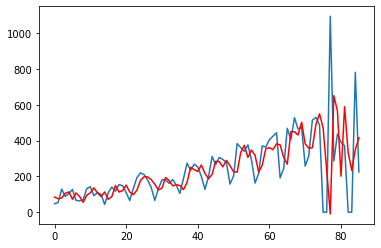

In [84]:
t = np.asarray(df_ch['new_cases'])
X = t
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()